# Import libraries

In [ ]:
!pip install pandas_ta
!pip install torch torchvision

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas_ta as ta
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import random
from copy import deepcopy
from torch.optim import Adam
from torch.nn import MSELoss
import copy

## Microsoft

### Data Insights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Microsoft = pd.read_csv('/content/drive/MyDrive/ML_project/Data/Microsoft_weekly.csv')

In [ ]:
Microsoft.head()

,Date,Open,High,Low,Close,Volume
0,1994-03-06,81.25,83.25,80.50,1.8029,7166700
1,1994-03-13,81.25,82.25,79.75,1.8194,5429200
2,1994-03-20,82.50,85.25,82.25,1.8860,7539800
3,1994-03-27,85.00,89.25,82.25,1.9473,13523800
4,1994-04-03,87.50,88.00,82.50,1.8860,11122900


In [ ]:
Microsoft.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

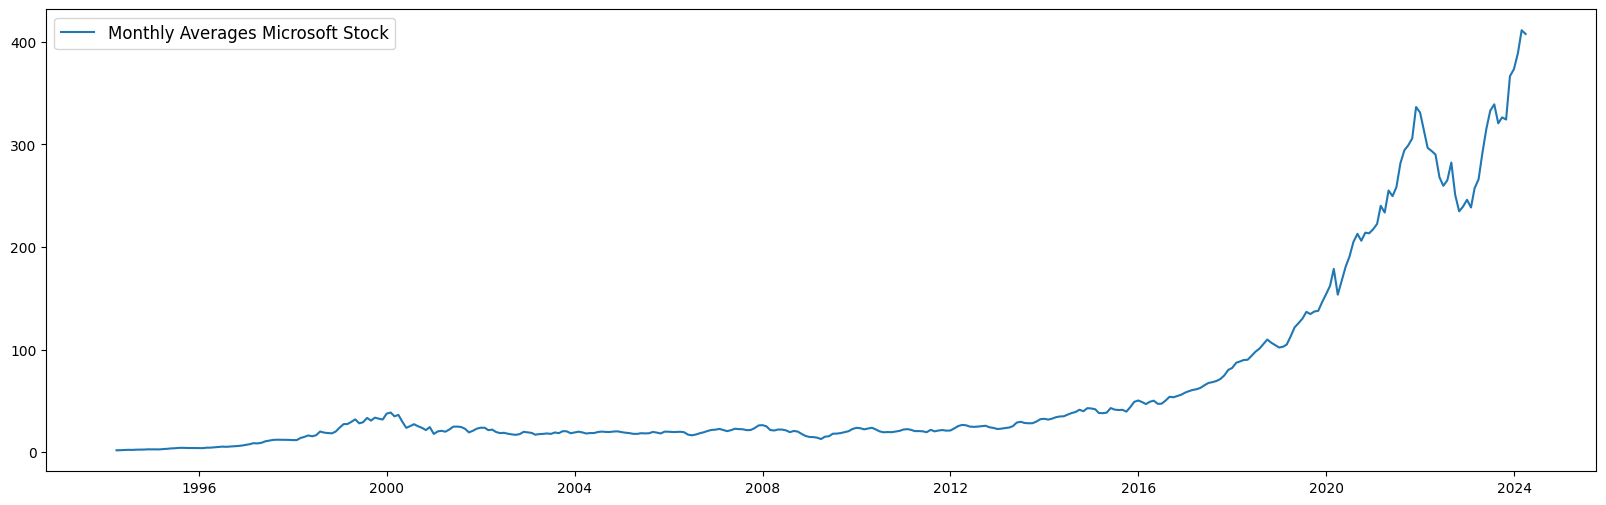

In [ ]:
Microsoft['Date'] = pd.to_datetime(Microsoft.Date)
newMicrosoft = Microsoft.set_index('Date')
# Resample the data to the monthly level
monthly_data = newMicrosoft[['Close', 'Open', 'High', 'Low', 'Volume']].resample('M').mean()
##Monthly Stock Price
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_data['Close'],label='Monthly Averages Microsoft Stock')
plt.legend(prop={'size': 12})
plt.show()

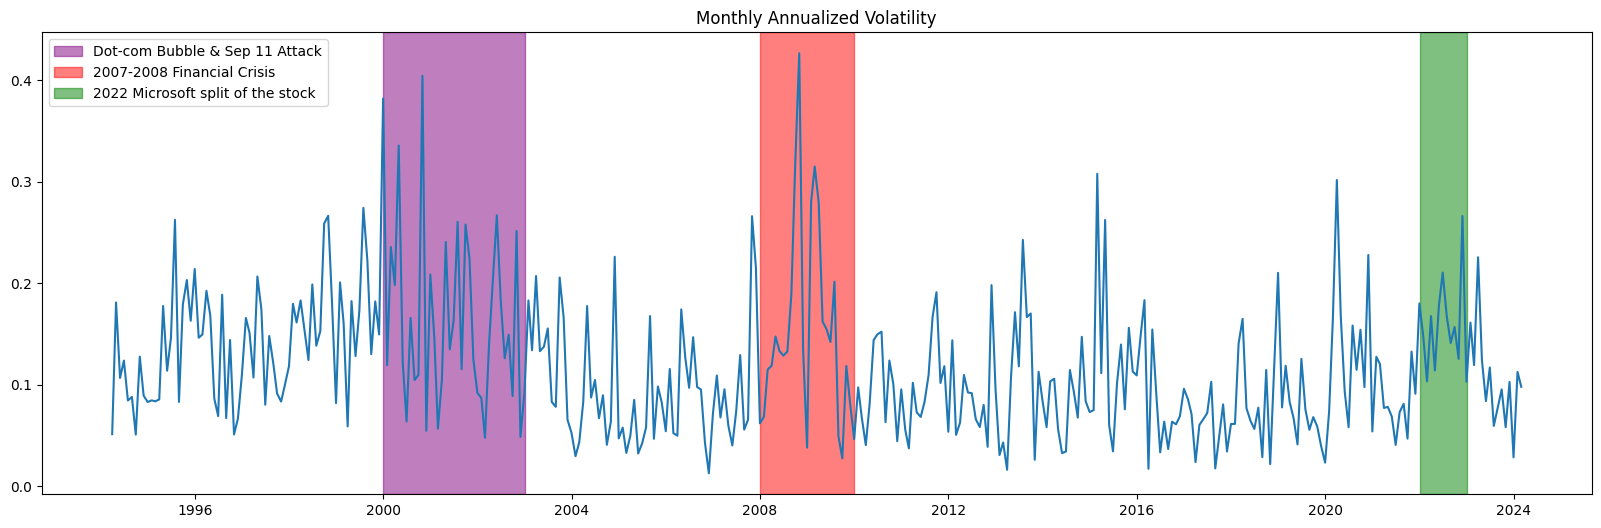

In [ ]:
# Calculate weekly returns using percentage change
weekly_returns = newMicrosoft['Close'].pct_change()
weekly_returns.dropna(inplace=True)

# Resample to monthly data and calculate the standard deviation as a measure of volatility
# Then annualize the monthly volatility
monthly_volatility = weekly_returns.resample("M").std() * np.sqrt(12)

# Visualize major market events reflected in volatility
plt.figure(figsize=(20, 6))
plt.plot(monthly_volatility)
plt.axvspan('2000', '2003', color='purple', alpha=.5)
plt.axvspan('2008', '2010', color='red', alpha=.5)
plt.axvspan('2022', '2023', color='green', alpha=.5)
plt.title("Monthly Annualized Volatility")

# Add legend for major market events
l1 = mpatches.Patch(color='purple', alpha=.5, label="Dot-com Bubble & Sep 11 Attack")
l2 = mpatches.Patch(color='red', alpha=.5, label="2007-2008 Financial Crisis")
l3 = mpatches.Patch(color='green', alpha=.5, label="2022 Microsoft split of the stock")
plt.legend(handles=[l1, l2, l3])

plt.show()

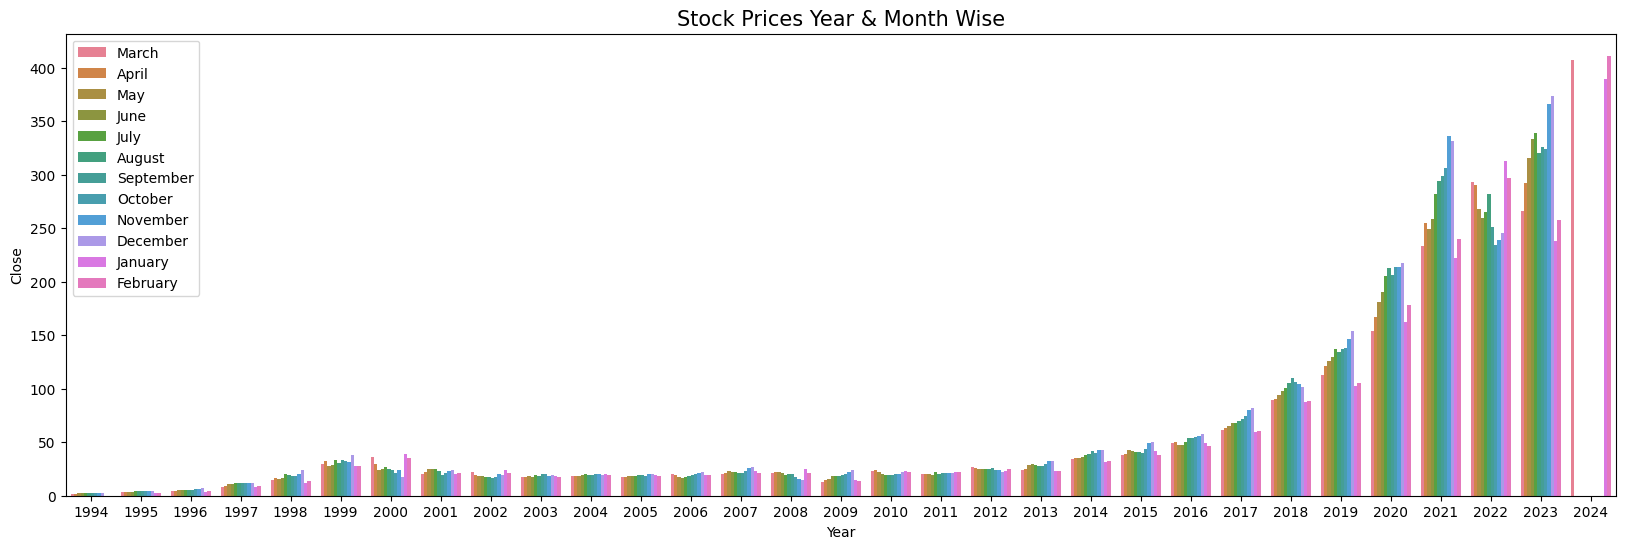

In [ ]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['Quarter'] = monthly_data.index.quarter
fig, ax = plt.subplots(figsize=(20,6))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.savefig("/content/drive/MyDrive/aaa.png", transparent=True)
plt.show()

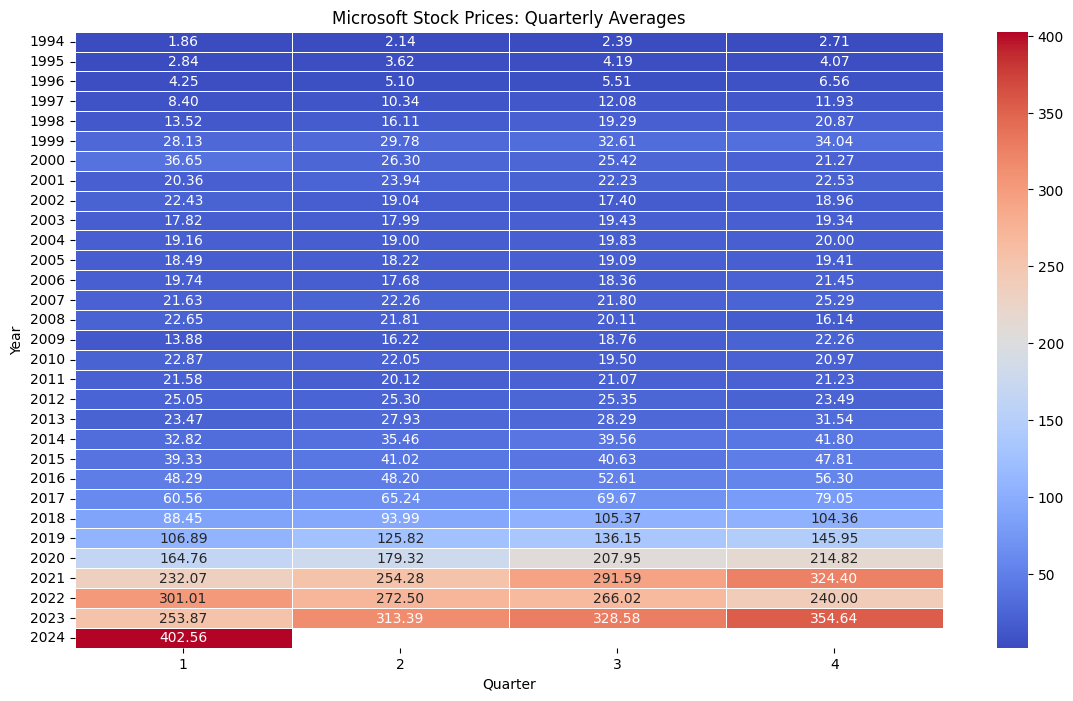

In [ ]:
quarter = monthly_data.groupby(["Year", "Quarter"])["Close"].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(quarter, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("Microsoft Stock Prices: Quarterly Averages")
plt.show()

### Data Preparation

#### Target Construction

In [ ]:
# Create Log(Return)
# Calculate logarithmic returns
Microsoft['Log_Return'] = np.log(Microsoft['Close'] / Microsoft['Close'].shift(1))
Microsoft['Log_Return'].fillna(0, inplace=True)  # Handle NaN values resulting from the shift

#### Covariates construction

In [ ]:
# Calculate Simple Moving Average (SMA)
Microsoft['SMA_50'] = ta.sma(Microsoft['Close'], length=50)  # 50-period SMA
Microsoft['SMA_200'] = ta.sma(Microsoft['Close'], length=200)  # 200-period SMA

# Calculate Exponential Moving Average (EMA)
Microsoft['EMA_12'] = ta.ema(Microsoft['Close'], length=12)  # 12-period EMA
Microsoft['EMA_26'] = ta.ema(Microsoft['Close'], length=26)  # 26-period EMA

# Calculate the Stochastic Oscillator components
stoch = ta.stoch(Microsoft['High'], Microsoft['Low'], Microsoft['Close'])
Microsoft = Microsoft.join(stoch)

# Calculate Relative Strength Index (RSI)
Microsoft['RSI_14'] = ta.rsi(Microsoft['Close'], length=14)  # 14-period RSI

# Calculate Moving Average Convergence Divergence (MACD)
macd = ta.macd(Microsoft['Close'])
Microsoft = Microsoft.join(macd)

In [ ]:
Microsoft['Date'] = pd.to_datetime(Microsoft['Date'])
Microsoft.set_index('Date', inplace=True)

In [ ]:
# Handle NaN:
Microsoft.dropna(inplace=True)

In [ ]:
Microsoft.shape

(1367, 16)

In [ ]:
dates = Microsoft.index

In [ ]:
# Calculate split indices
split_idx_train = int(len(Microsoft) * 0.7)
split_idx_val = int(len(Microsoft) * 0.9)

# Drop the specified columns and define the features and labels
X_Microsoft = Microsoft.drop(['Log_Return'], axis=1)
y_Microsoft = Microsoft['Log_Return']  # Log_Return as the target variable

# Ensure that indices are reset before splitting to avoid potential issues
X_Microsoft.reset_index(drop=True, inplace=True)
y_Microsoft.reset_index(drop=True, inplace=True)

# Split into training, validation, and testing sets
X_Microsoft_train = X_Microsoft.iloc[:split_idx_train, :]
X_Microsoft_val = X_Microsoft.iloc[split_idx_train:split_idx_val, :]
X_Microsoft_test = X_Microsoft.iloc[split_idx_val:, :]

y_Microsoft_train = y_Microsoft.iloc[:split_idx_train]
y_Microsoft_val = y_Microsoft.iloc[split_idx_train:split_idx_val]
y_Microsoft_test = y_Microsoft.iloc[split_idx_val:]

In [ ]:
Microsoft_dates_test = dates[split_idx_val:]

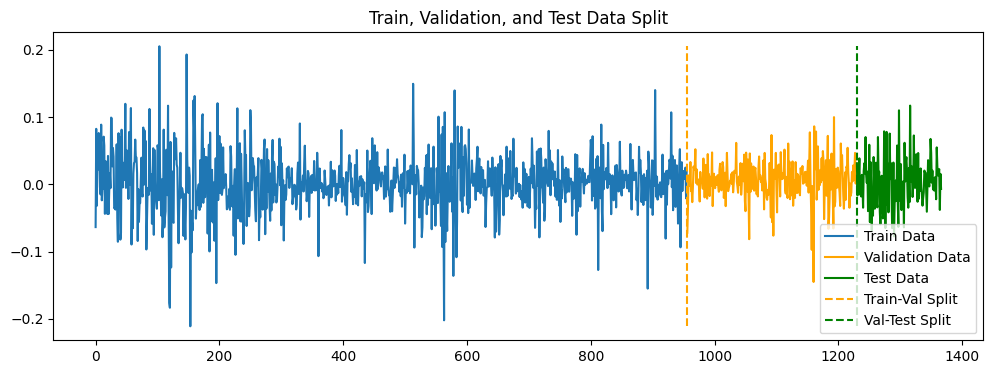

In [ ]:
# Indices for plotting
x_train = np.arange(len(y_Microsoft_train))
x_val = np.arange(len(y_Microsoft_train), len(y_Microsoft_train) + len(y_Microsoft_val))
x_test = np.arange(len(y_Microsoft_train) + len(y_Microsoft_val), len(y_Microsoft))

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(x_train, y_Microsoft_train, label="Train Data")
plt.plot(x_val, y_Microsoft_val, color='orange', label="Validation Data")
plt.plot(x_test, y_Microsoft_test, color='green', label="Test Data")
plt.vlines(len(y_Microsoft_train), ymin=min(y_Microsoft.min(), y_Microsoft.min(), y_Microsoft.min()), ymax=max(y_Microsoft.max(), y_Microsoft.max(), y_Microsoft.max()), label='Train-Val Split', linestyles='dashed', colors='orange')
plt.vlines(len(y_Microsoft_train) + len(y_Microsoft_val), ymin=min(y_Microsoft.min(), y_Microsoft.min(), y_Microsoft.min()), ymax=max(y_Microsoft.max(), y_Microsoft.max(), y_Microsoft.max()), label='Val-Test Split', linestyles='dashed', colors='green')
plt.legend()
plt.title("Train, Validation, and Test Data Split")
plt.show()

### Data Preprocessing

In [ ]:
from sklearn.preprocessing import power_transform

# Fit the transformer on the training data and transform it
X_Microsoft_train_transformed = power_transform(X_Microsoft_train.to_numpy(), method='yeo-johnson')

# Transform the validation data using the same transformer
X_Microsoft_val_transformed = power_transform(X_Microsoft_val.to_numpy(), method='yeo-johnson')

# Transform the test data using the same transformer
X_Microsoft_test_transformed = power_transform(X_Microsoft_test.to_numpy(), method='yeo-johnson')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_Microsoft_train_scaled = scaler.fit_transform(X_Microsoft_train_transformed)

# Transform the val data using the same scaler
X_Microsoft_val_scaled = scaler.transform(X_Microsoft_val_transformed)

# Transform the test data using the same scaler
X_Microsoft_test_scaled = scaler.transform(X_Microsoft_test_transformed)

In [ ]:
print(X_Microsoft_train_scaled.shape)
print(X_Microsoft_val_scaled.shape)
print(X_Microsoft_test_scaled.shape)

(956, 15)
(274, 15)
(137, 15)


### Models

#### Loss function: RMSE

##### RNNs

In [ ]:
!ls "/content/drive/MyDrive/ML_project/Colab"

 Amazon.ipynb   Cac.ipynb   Master.ipynb      Nasdaq.ipynb   __pycache__      Sp500.ipynb
 anns.py        IBM.ipynb   Microsoft.ipynb  'old files'    'RMSE all(RNN)'


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ML_project/Colab')
from anns import EnhancedSignAgreementLoss, rnns, create_sequences_rnns, SimpleRNN, RMSELoss

In [ ]:
# Ensure y_Microsoft_train and y_test are numpy arrays
y_Microsoft_train = y_Microsoft_train.to_numpy() if isinstance(y_Microsoft_train, pd.Series) else y_Microsoft_train
y_Microsoft_val = y_Microsoft_val.to_numpy() if isinstance(y_Microsoft_val, pd.Series) else y_Microsoft_val
y_Microsoft_test = y_Microsoft_test.to_numpy() if isinstance(y_Microsoft_test, pd.Series) else y_Microsoft_test

# Create sequences
time_steps = 10
X_Microsoft_train_seq, y_Microsoft_train_seq = create_sequences_rnns(X_Microsoft_train_scaled, y_Microsoft_train, time_steps)
X_Microsoft_val_seq, y_Microsoft_val_seq = create_sequences_rnns(X_Microsoft_val_scaled, y_Microsoft_val, time_steps)
X_Microsoft_test_seq, y_Microsoft_test_seq = create_sequences_rnns(X_Microsoft_test_scaled, y_Microsoft_test, time_steps)

X_Microsoft_train_tensor = torch.tensor(X_Microsoft_train_seq, dtype=torch.float32)
y_Microsoft_train_tensor = torch.tensor(y_Microsoft_train_seq, dtype=torch.float32)
X_Microsoft_val_tensor = torch.tensor(X_Microsoft_val_seq, dtype=torch.float32)
y_Microsoft_val_tensor = torch.tensor(y_Microsoft_val_seq, dtype=torch.float32)
X_Microsoft_test_tensor = torch.tensor(X_Microsoft_test_seq, dtype=torch.float32)
y_Microsoft_test_tensor = torch.tensor(y_Microsoft_test_seq, dtype=torch.float32)

# Prepare data loaders
Microsoft_train_dataset = TensorDataset(X_Microsoft_train_tensor, y_Microsoft_train_tensor)
Microsoft_train_loader = DataLoader(dataset=Microsoft_train_dataset, batch_size=32, shuffle=False)
Microsoft_val_dataset = TensorDataset(X_Microsoft_val_tensor, y_Microsoft_val_tensor)
Microsoft_val_loader = DataLoader(dataset=Microsoft_val_dataset, batch_size=32, shuffle=False)

# Prepare data for prediction
Microsoft_predict_dataset = TensorDataset(X_Microsoft_test_tensor, y_Microsoft_test_tensor)
Microsoft_predict_loader = DataLoader(Microsoft_predict_dataset, batch_size=32, shuffle=False)

In [ ]:
X_Microsoft_train_tensor.shape

torch.Size([946, 10, 15])

In [ ]:
# Set seed for NumPy
np.random.seed(20)

# Set seed for PyTorch
torch.manual_seed(20)

In [ ]:
# Initialize the RNN model
Microsoft_rnns_rmse = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(Microsoft_rnns_rmse.parameters(), lr=0.001)
loss_function = RMSELoss()
epochs = 100

best_model_state, best_val_loss = rnns(Microsoft_rnns_rmse, Microsoft_train_loader, Microsoft_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 0.06064137816429138, Val Loss: 0.08710544556379318
Epoch 11, Train Loss: 0.04238610714673996, Val Loss: 0.0465703159570694
Epoch 21, Train Loss: 0.02981794998049736, Val Loss: 0.04192129522562027
Epoch 31, Train Loss: 0.03856963291764259, Val Loss: 0.05151677504181862
Epoch 41, Train Loss: 0.02580764889717102, Val Loss: 0.046861644834280014
Epoch 51, Train Loss: 0.03818562999367714, Val Loss: 0.05053021013736725
Epoch 61, Train Loss: 0.05875268206000328, Val Loss: 0.041476015001535416
Epoch 71, Train Loss: 0.0481703095138073, Val Loss: 0.04807289317250252
Epoch 81, Train Loss: 0.030312582850456238, Val Loss: 0.05607439950108528
Epoch 91, Train Loss: 0.035888124257326126, Val Loss: 0.04699329659342766


In [ ]:
best_val_loss

tensor(0.0380)

In [ ]:
Microsoft_rnns_rmse.load_state_dict(best_model_state)
Microsoft_rnns_rmse.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
Microsoft_predictions = []
Microsoft_actuals = []

with torch.no_grad():
    for inputs, labels in Microsoft_predict_loader:
        outputs = Microsoft_rnns_rmse(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        Microsoft_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        Microsoft_actuals.extend(labels.cpu().numpy())

In [ ]:
Microsoft_rnns_rmse_predictions = np.array(Microsoft_predictions)
Microsoft_rnns_rmse_actuals = np.array(Microsoft_actuals)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming Microsoft_rnns_rmse_predictions and Microsoft_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
Microsoft_rnns_rmse_predicted_labels = (Microsoft_rnns_rmse_predictions >= 0).astype(int)
Microsoft_rnns_rmse_actual_labels = (Microsoft_rnns_rmse_actuals >= 0).astype(int)

# Calculate classifier metrics
Microsoft_rnns_rmse_accuracy = accuracy_score(Microsoft_rnns_rmse_actual_labels, Microsoft_rnns_rmse_predicted_labels)
Microsoft_rnns_rmse_precision = precision_score(Microsoft_rnns_rmse_actual_labels, Microsoft_rnns_rmse_predicted_labels)
Microsoft_rnns_rmse_recall = recall_score(Microsoft_rnns_rmse_actual_labels, Microsoft_rnns_rmse_predicted_labels)
Microsoft_rnns_rmse_f1 = f1_score(Microsoft_rnns_rmse_actual_labels, Microsoft_rnns_rmse_predicted_labels)

# Print the classification metrics
print("Accuracy:", Microsoft_rnns_rmse_accuracy)
print("Precision:", Microsoft_rnns_rmse_precision)
print("Recall:", Microsoft_rnns_rmse_recall)
print("F1 Score:", Microsoft_rnns_rmse_f1)

Accuracy: 0.4409448818897638
Precision: 0.4626865671641791
Recall: 0.4696969696969697
F1 Score: 0.4661654135338346


###### Plots

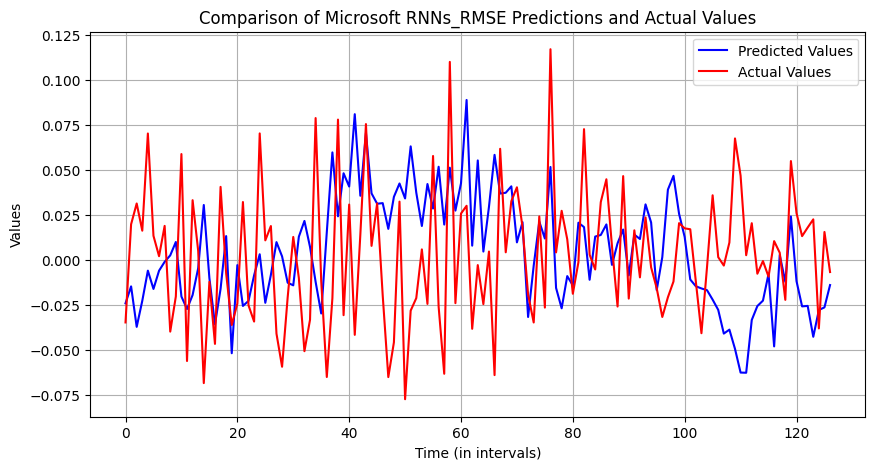

In [ ]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(Microsoft_rnns_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(Microsoft_rnns_rmse_actuals, label='Actual Values', color='red')
plt.title('Comparison of Microsoft RNNs_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/1.png", transparent=True)
plt.show()

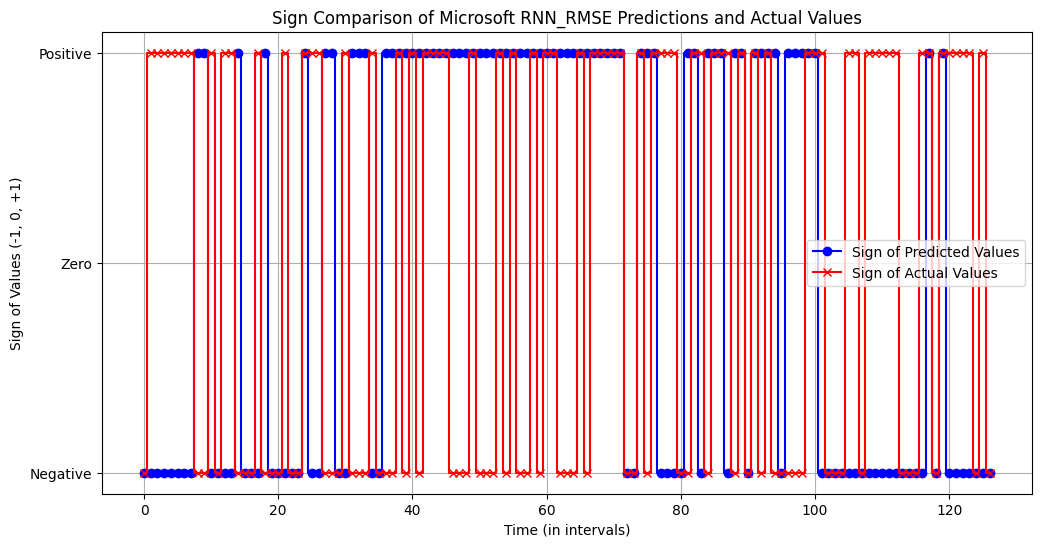

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(Microsoft_rnns_rmse_predictions)
signs_actuals_rnn = np.sign(Microsoft_rnns_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of Microsoft RNN_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [ ]:
X_Microsoft_train_anfis = torch.tensor(X_Microsoft_train_scaled, dtype=torch.float32)
y_Microsoft_train_anfis = torch.tensor(y_Microsoft_train, dtype=torch.float32)
X_Microsoft_val_anfis = torch.tensor(X_Microsoft_val_scaled, dtype=torch.float32)
y_Microsoft_val_anfis = torch.tensor(y_Microsoft_val, dtype=torch.float32)
X_Microsoft_test_anfis = torch.tensor(X_Microsoft_test_scaled, dtype=torch.float32)
y_Microsoft_test_anfis = torch.tensor(y_Microsoft_test, dtype=torch.float32)

In [ ]:
X_Microsoft_train_anfis.shape

torch.Size([956, 15])

In [ ]:
from anns import ANFIS_RMSE
input_dim = X_Microsoft_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.005

# Initialize the ANFIS model
Microsoft_anfis_rmse = ANFIS_RMSE(functions=functions, input_dim=input_dim)

# Train the model
Microsoft_anfis_rmse.fit(X_Microsoft_train_anfis, y_Microsoft_train_anfis
                      , X_Microsoft_val_anfis, y_Microsoft_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
Microsoft_anfis_rmse_predictions = Microsoft_anfis_rmse.predict(X_Microsoft_test_anfis)

Epoch 1/100, Train Loss: 0.0384, Validation Loss: 0.0190
Epoch 11/100, Train Loss: 0.0017, Validation Loss: 0.0011
Epoch 21/100, Train Loss: 0.0017, Validation Loss: 0.0013
Epoch 31/100, Train Loss: 0.0016, Validation Loss: 0.0016
Epoch 41/100, Train Loss: 0.0016, Validation Loss: 0.0017
Epoch 51/100, Train Loss: 0.0015, Validation Loss: 0.0014
Epoch 61/100, Train Loss: 0.0014, Validation Loss: 0.0014
Epoch 71/100, Train Loss: 0.0013, Validation Loss: 0.0014
Epoch 81/100, Train Loss: 0.0013, Validation Loss: 0.0011
Epoch 91/100, Train Loss: 0.0012, Validation Loss: 0.0013
Best Validation Loss: 0.0010


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
Microsoft_anfis_rmse_predictions = Microsoft_anfis_rmse_predictions.detach().cpu().numpy()
Microsoft_anfis_rmse_actuals = y_Microsoft_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
# Positive sign (including zero for simplicity in binary classification) will be 1
# Negative sign will be 0
def sign_classify(values):
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(Microsoft_anfis_rmse_predictions)
actual_signs = sign_classify(Microsoft_anfis_rmse_actuals)

# Calculate metrics directly comparing predicted and actual signs
Microsoft_anfis_rmse_accuracy = accuracy_score(actual_signs, predicted_signs)
Microsoft_anfis_rmse_precision = precision_score(actual_signs, predicted_signs)
Microsoft_anfis_rmse_recall = recall_score(actual_signs, predicted_signs)
Microsoft_anfis_rmse_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", Microsoft_anfis_rmse_accuracy)
print("Precision:", Microsoft_anfis_rmse_precision)
print("Recall:", Microsoft_anfis_rmse_recall)
print("F1 Score:", Microsoft_anfis_rmse_f1)

Accuracy: 0.7518248175182481
Precision: 0.7317073170731707
Recall: 0.8333333333333334
F1 Score: 0.7792207792207793


###### Plots

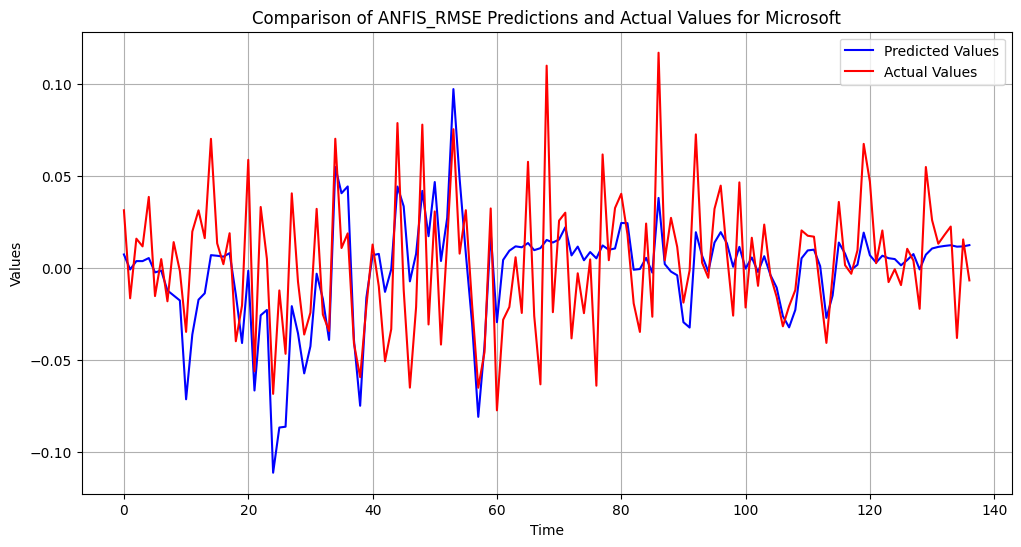

In [ ]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(Microsoft_anfis_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(Microsoft_anfis_rmse_actuals, label='Actual Values', color='red')
plt.title('Comparison of ANFIS_RMSE Predictions and Actual Values for Microsoft')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/2.png", transparent=True)
plt.show()

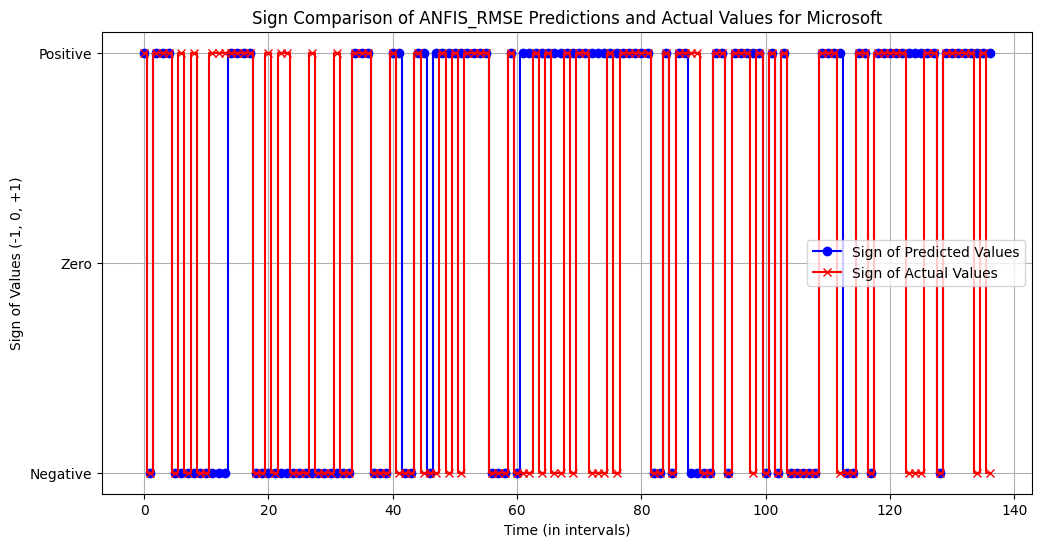

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(Microsoft_anfis_rmse_predictions)
signs_actuals = np.sign(Microsoft_anfis_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_RMSE Predictions and Actual Values for Microsoft')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

#### Custom loss function

##### RNNs

In [ ]:
from anns import EnhancedSignAgreementLoss
# Initialize the RNN model
Microsoft_rnns_custom = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(Microsoft_rnns_custom.parameters(), lr=0.001)
loss_function = EnhancedSignAgreementLoss(loss_penalty=5000)
epochs = 100

best_model_state, best_val_loss = rnns(Microsoft_rnns_custom, Microsoft_train_loader, Microsoft_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 2222.2294921875, Val Loss: 2638.9033203125
Epoch 11, Train Loss: 2777.78076171875, Val Loss: 1927.0848388671875
Epoch 21, Train Loss: 2777.77880859375, Val Loss: 2361.11279296875
Epoch 31, Train Loss: 2222.223388671875, Val Loss: 2500.001708984375
Epoch 41, Train Loss: 2222.22314453125, Val Loss: 2343.751708984375
Epoch 51, Train Loss: 1666.6678466796875, Val Loss: 2361.113037109375
Epoch 61, Train Loss: 1666.6676025390625, Val Loss: 2413.1962890625
Epoch 71, Train Loss: 2500.00048828125, Val Loss: 2361.11279296875
Epoch 81, Train Loss: 1666.66748046875, Val Loss: 2326.390380859375
Epoch 91, Train Loss: 2222.22314453125, Val Loss: 2222.2236328125


In [ ]:
best_val_loss

tensor(1684.0288)

In [ ]:
Microsoft_rnns_custom.load_state_dict(best_model_state)
Microsoft_rnns_custom.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
Microsoft_predictions = []
Microsoft_actuals = []

with torch.no_grad():
    for inputs, labels in Microsoft_predict_loader:
        outputs = Microsoft_rnns_custom(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        Microsoft_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        Microsoft_actuals.extend(labels.cpu().numpy())

In [ ]:
Microsoft_rnns_custom_predictions = np.array(Microsoft_predictions)
Microsoft_rnns_custom_actuals = np.array(Microsoft_actuals)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming Microsoft_rnns_rmse_predictions and Microsoft_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
Microsoft_rnns_custom_predicted_labels = (Microsoft_rnns_custom_predictions >= 0).astype(int)
Microsoft_rnns_custom_actual_labels = (Microsoft_rnns_custom_actuals >= 0).astype(int)

# Calculate classifier metrics
Microsoft_rnns_custom_accuracy = accuracy_score(Microsoft_rnns_custom_actual_labels, Microsoft_rnns_custom_predicted_labels)
Microsoft_rnns_custom_precision = precision_score(Microsoft_rnns_custom_actual_labels, Microsoft_rnns_custom_predicted_labels)
Microsoft_rnns_custom_recall = recall_score(Microsoft_rnns_custom_actual_labels, Microsoft_rnns_custom_predicted_labels)
Microsoft_rnns_custom_f1 = f1_score(Microsoft_rnns_custom_actual_labels, Microsoft_rnns_custom_predicted_labels)

# Print the classification metrics
print("Accuracy:", Microsoft_rnns_custom_accuracy)
print("Precision:", Microsoft_rnns_custom_precision)
print("Recall:", Microsoft_rnns_custom_recall)
print("F1 Score:", Microsoft_rnns_custom_f1)

Accuracy: 0.5433070866141733
Precision: 0.5666666666666667
Recall: 0.5151515151515151
F1 Score: 0.5396825396825397


###### Plots

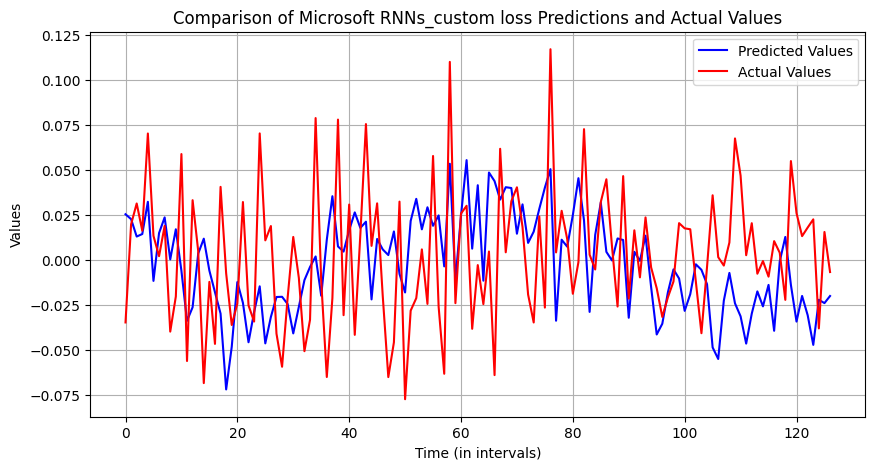

In [ ]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(Microsoft_rnns_custom_predictions, label='Predicted Values', color='blue')
plt.plot(Microsoft_rnns_custom_actuals, label='Actual Values', color='red')
plt.title('Comparison of Microsoft RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/3.png", transparent=True)
plt.show()

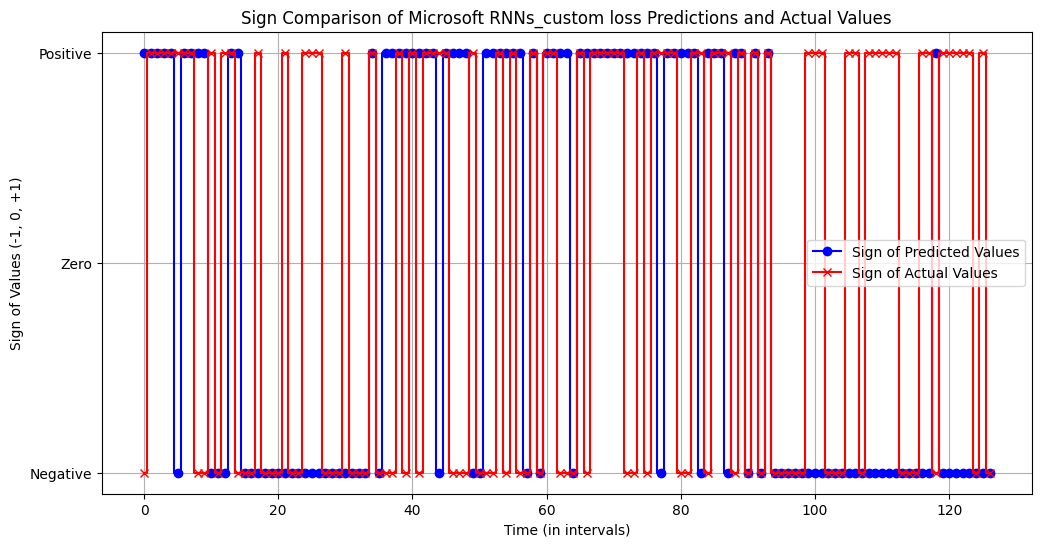

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(Microsoft_rnns_custom_predictions)
signs_actuals_rnn = np.sign(Microsoft_rnns_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of Microsoft RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [ ]:
from anns import ANFIS_CustomLoss

input_dim = X_Microsoft_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.008

# Initialize the ANFIS model
Microsoft_anfis_custom = ANFIS_CustomLoss(functions=functions, input_dim=input_dim, loss_penalty=10000)

# Train the model
Microsoft_anfis_custom.fit(X_Microsoft_train_anfis, y_Microsoft_train_anfis
                      , X_Microsoft_val_anfis, y_Microsoft_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
Microsoft_anfis_custom_predictions = Microsoft_anfis_custom.predict(X_Microsoft_test_anfis)

Epoch 1/100, Train Loss: 4926.7927, Val Loss: 4197.0822
Epoch 11/100, Train Loss: 3859.8343, Val Loss: 4270.0739
Epoch 21/100, Train Loss: 3629.7085, Val Loss: 5401.4608
Epoch 31/100, Train Loss: 3274.0600, Val Loss: 4197.0816
Epoch 41/100, Train Loss: 3169.4574, Val Loss: 5036.4979
Epoch 51/100, Train Loss: 2730.1267, Val Loss: 3649.6361
Epoch 61/100, Train Loss: 2615.0638, Val Loss: 4051.0961
Epoch 71/100, Train Loss: 2552.3023, Val Loss: 3868.6144
Epoch 81/100, Train Loss: 2479.0804, Val Loss: 4160.5857
Epoch 91/100, Train Loss: 2374.4779, Val Loss: 4233.5784
Best Validation Loss: 3430.6579


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
Microsoft_anfis_custom_predictions = Microsoft_anfis_custom_predictions.detach().cpu().numpy()
Microsoft_anfis_custom_actuals = y_Microsoft_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
def sign_classify(values):
    # Convert positive and zero values to 1, and negative values to 0
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(Microsoft_anfis_custom_predictions)
actual_signs = sign_classify(Microsoft_anfis_custom_actuals)

# Calculate metrics directly using predicted and actual signs
Microsoft_anfis_custom_accuracy = accuracy_score(actual_signs, predicted_signs)
Microsoft_anfis_custom_precision = precision_score(actual_signs, predicted_signs)
Microsoft_anfis_custom_recall = recall_score(actual_signs, predicted_signs)
Microsoft_anfis_custom_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", Microsoft_anfis_custom_accuracy)
print("Precision:", Microsoft_anfis_custom_precision)
print("Recall:", Microsoft_anfis_custom_recall)
print("F1 Score:", Microsoft_anfis_custom_f1)

Accuracy: 0.7591240875912408
Precision: 0.7191011235955056
Recall: 0.8888888888888888
F1 Score: 0.7950310559006211


###### Plots

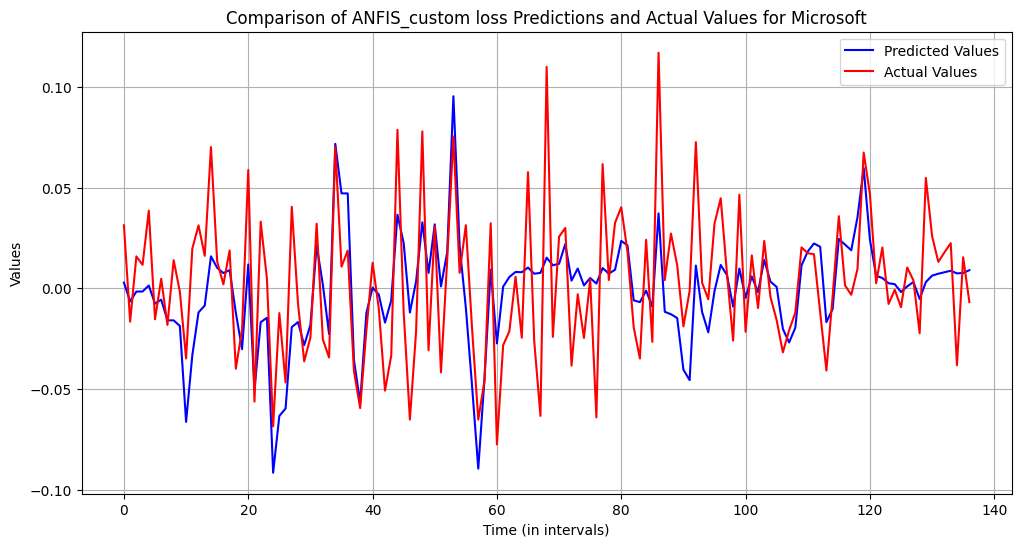

In [ ]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(Microsoft_anfis_custom_predictions, label='Predicted Values', color='blue')
plt.plot(Microsoft_anfis_custom_actuals, label='Actual Values', color='red')
plt.title('Comparison of ANFIS_custom loss Predictions and Actual Values for Microsoft')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/4.png", transparent=True)
plt.show()

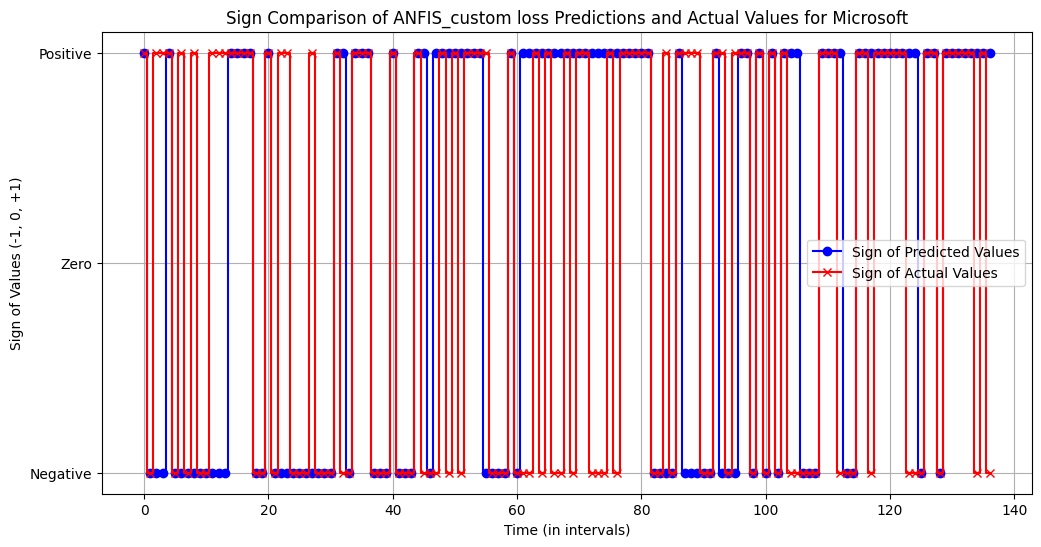

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(Microsoft_anfis_custom_predictions)
signs_actuals = np.sign(Microsoft_anfis_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_custom loss Predictions and Actual Values for Microsoft')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()